In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lasagne
import theano
import theano.tensor as T
import seaborn

import logging
logging.basicConfig(level=logging.INFO)

from utils import load_configs

from robo.models.lcnet import LCNet, get_lc_net


seaborn.set_style(style='whitegrid')
current_palette = seaborn.color_palette("Paired", 10)
seaborn.set_palette(current_palette)

plt.rc('text', usetex=True)
plt.rc('font', size=15.0, family='serif')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

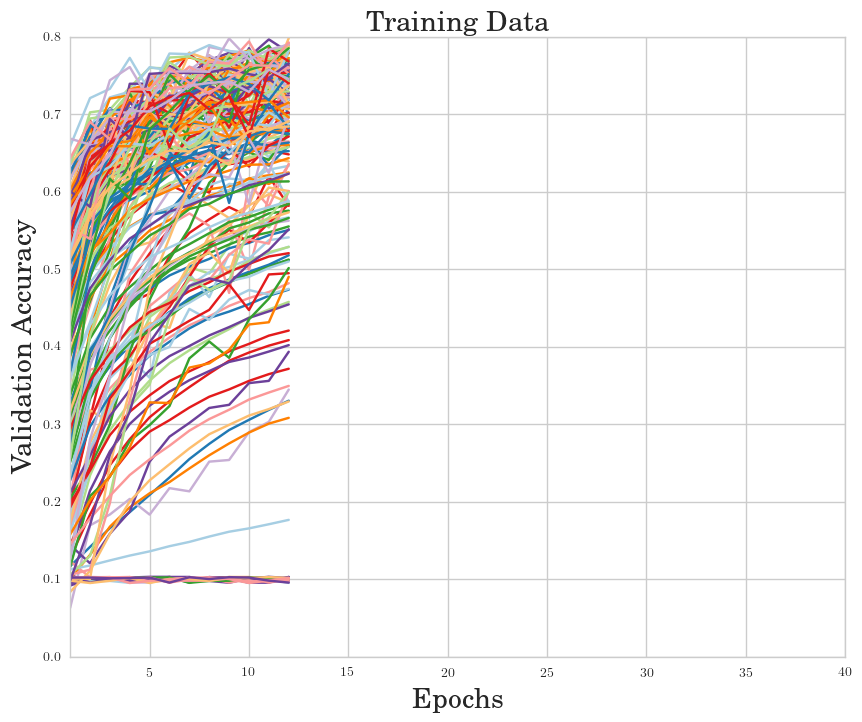

In [ ]:
observed = 30
N = 200
n_epochs = 40

configs, learning_curves = load_configs("/mhome/kleinaa/experiments/learning_curve_prediction/datasets/conv_net_cifar10/", N)

learning_curves = 1 - learning_curves

shuffle = np.random.permutation(N)
configs = configs[shuffle]
learning_curves = learning_curves[shuffle]

observed_t = int(n_epochs * (observed / 100.))

t_idx = np.arange(1, observed_t + 1) / n_epochs

X_train = None
y_train = None

for i in range(N):

    x = np.repeat(configs[i, None, :], t_idx.shape[0], axis=0)
    x = np.concatenate((x, t_idx[:, None]), axis=1)

    x_test = np.concatenate((configs[i, None, :], np.array([[1]])), axis=1)

    lc = learning_curves[i][:observed_t]
    lc_test = np.array([learning_curves[i][-1]])

    if X_train is None:
        X_train = x
        y_train = lc

    else:
        X_train = np.concatenate((X_train, x), 0)
        y_train = np.concatenate((y_train, lc), 0)
    
    plt.plot(t_idx * n_epochs, lc)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Validation Accuracy", fontsize=20)
plt.title("Training Data", fontsize=20)  
plt.xlim(1, n_epochs)
plt.show()

In [ ]:
model = LCNet(sampling_method="sghmc",
              l_rate=np.sqrt(1e-4),
              mdecay=0.05,
              n_nets=100,
              burn_in=30000,
              n_iters=50000,
              get_net=get_lc_net,
              precondition=True)

model.train(X_train, y_train)

INFO:root:Starting sampling


... compiling theano function


INFO:root:Iter        0 : NLL =  4.3720e+00 MSE = 3.8945e-02 Time =  9.95
INFO:root:Iter      512 : NLL =  3.2715e-01 MSE = 1.7914e-02 Time = 11.91
INFO:root:Iter     1024 : NLL = -2.8082e-01 MSE = 1.0573e-02 Time = 13.26
INFO:root:Iter     1536 : NLL = -1.0733e+00 MSE = 7.8689e-03 Time = 14.64
INFO:root:Iter     2048 : NLL = -6.0779e-01 MSE = 5.5927e-03 Time = 16.16
INFO:root:Iter     2560 : NLL = -9.1901e-01 MSE = 3.6974e-03 Time = 18.11
INFO:root:Iter     3072 : NLL = -1.2454e+00 MSE = 3.7163e-03 Time = 20.01
INFO:root:Iter     3584 : NLL = -1.2271e+00 MSE = 4.1649e-03 Time = 21.46
INFO:root:Iter     4096 : NLL = -8.3508e-01 MSE = 6.5614e-03 Time = 23.09
INFO:root:Iter     4608 : NLL = -1.3451e+00 MSE = 3.8757e-03 Time = 24.58
INFO:root:Iter     5120 : NLL = -1.1883e+00 MSE = 4.7607e-03 Time = 26.09
INFO:root:Iter     5632 : NLL = -1.2827e+00 MSE = 3.1923e-03 Time = 28.53
INFO:root:Iter     6144 : NLL = -1.3698e+00 MSE = 2.7003e-03 Time = 29.98
INFO:root:Iter     6656 : NLL =  1.005

In [ ]:
test_config = 1
x = configs[test_config, None, :]
epochs = np.arange(1, n_epochs+1)
idx = epochs / n_epochs
x = np.repeat(x, idx.shape[0], axis=0)
x = np.concatenate((x, idx[:, None]), axis=1)
y_test = learning_curves[test_config].flatten()

m, v = model.predict(x)
s = np.sqrt(v)

plt.plot(epochs, y_test, color="black", label="True Learning Curve", linewidth=3)


f, noise = model.predict(x, return_individual_predictions=True)

[plt.plot(epochs, fi, color="blue", alpha=0.08) for fi in f]

plt.plot(epochs, m, color="red", label="LC-Net", linewidth=3)
plt.legend(loc=2, fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Validation Accuracy", fontsize=20)
plt.xlim(1, n_epochs)
plt.axvline(observed_t, linestyle="--", color="grey")
plt.show()


In [ ]:
l = lasagne.layers.get_all_layers(model.net)[:-7]
bf = lasagne.layers.get_output(l, x)[-1].eval()

plt.plot(epochs, y_test, color="black", label="True Learning Curve")
plt.plot(epochs, bf[:, 0], label="vapor pressure")
plt.plot(epochs, bf[:, 1], label="pow-func")
plt.plot(epochs, bf[:, 2], label="log power")
plt.plot(epochs, bf[:, 3], label="exponential")
plt.plot(epochs, bf[:, 4], label="hill-3")

l = lasagne.layers.get_all_layers(model.net)[:-3]
infty = lasagne.layers.get_output(l, x)[-1].eval()

plt.plot(epochs, infty[:, 0], label=r"$\hat{y}_{\infty}$")

l = lasagne.layers.get_all_layers(model.net)[:-2]
mean = lasagne.layers.get_output(l, x)[-1].eval()

plt.plot(epochs, mean[:, 0], label="mean")

plt.legend(loc=4, fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Validation Accuracy", fontsize=20)
plt.xlim(1, n_epochs)
plt.ylim(-2, 2)
plt.show()

In [ ]:
l = lasagne.layers.get_all_layers(model.net)[:-6]
weights = lasagne.layers.get_output(l, x)[-1].eval()

plt.bar(np.arange(5), weights[0])
plt.xticks(np.arange(5)+.4, ["vapor pressure", "pow-func", "log-power", "exponential", "hill-3"])
plt.show()